# Tutorial for ReVeaL usage and example downstream analytics

In [11]:
import os, sys, re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shutil

## Read in data

For the purposes of this tutorial, the example data is WES from TCGA for prostate and breast cancer patients for sake of file size and because they are non-controlled data.

However ReVeaL's true application is for WGS data where alterations in the non-genic regions are less well characterized.

In [2]:
tcga_prad = pd.read_csv( 'TCGA_PRAD_maf_select.csv' )
tcga_brca = pd.read_csv( 'TCGA_BRCA_maf_select.csv' )


## Formatting for ReVeaL

In [3]:
tcga_prad_format = tcga_prad[[ 'patient_barcode', 'Chromosome', 'Start_Position', 'End_Position' ]] 
tcga_prad_format.loc[tcga_prad_format.index,'Chromosome'] = list( tcga_prad_format['Chromosome'].map( lambda x: re.sub( 'chr', '', str(x) ) ) )
tcga_prad_format.columns = [ 'samples', 'chromosome', 'start', 'stop' ]

tcga_brca_format = tcga_brca[[ 'patient_barcode', 'Chromosome', 'Start_Position', 'End_Position' ]] 
tcga_brca_format.loc[tcga_brca_format.index,'Chromosome'] = list( tcga_brca_format['Chromosome'].map( lambda x: re.sub( 'chr', '', str(x) ) ) )
tcga_brca_format.columns = [ 'samples', 'chromosome', 'start', 'stop' ]

tcga_reveal_input = pd.concat( [ tcga_prad_format, tcga_brca_format ] )
tcga_brca_format.to_csv( 'TCGA_maf_ReVealInput.tsv', sep = '\t', index = False )

In [4]:
# Make Labels File
tcga_labels = pd.DataFrame( list(zip( tcga_reveal_input['samples'].to_list(), ['PRAD'] * len(tcga_reveal_input) ) ) )
tcga_labels.columns = [ 'samples', 'phenotype' ]
tcga_labels.loc[ tcga_labels['samples'].isin( tcga_brca_format['samples'].to_list() ), 'phenotype'] = 'BRCA'
tcga_labels.to_csv( 'TCGA_labels_ReVealInput.csv', index = False )

In [5]:
# Make the Train Test File
tcga_trainTest = pd.DataFrame( [ ['PRAD', 'BRCA'], [10,10], [5,5] ] ).transpose()
tcga_trainTest.columns = [ 'phenotype', 'Train', 'Test' ]
tcga_trainTest.to_csv( 'TCGA_trainTest_ReVealInput.csv', index = False )

In [6]:
# Make the Regions File
region_file_genic = '../regions/genic.txt'
region_genic = pd.read_csv( region_file_genic, sep = '\t')
region_genic.head()

,chr,start,stop,extra
0,1,65419,71585,"gene_id ""OR4F5""; transcript_id """"; db_xref ""Ge..."
1,1,450740,451678,"gene_id ""OR4F29""; transcript_id """"; db_xref ""G..."
2,1,923923,944574,"gene_id ""SAMD11""; transcript_id """"; db_xref ""G..."
3,1,944203,959256,"gene_id ""NOC2L""; transcript_id """"; db_xref ""Ge..."
4,1,975198,982093,"gene_id ""PERM1""; transcript_id """"; db_xref ""Ge..."


## Running ReVeaL to create shingles

In [7]:
# Making Genic Shingles
os.system( 'python3 ../ReVeaL.py -s TCGA_maf_ReVealInput.tsv -l TCGA_labels_ReVealInput.csv -nf 10 -tt TCGA_trainTest_ReVealInput.csv -w 50000 -r ' + region_file_genic + ' -o output_folder' )

Traceback (most recent call last):
  File "../ReVeaL.py", line 154, in <module>
    args = build_parser()
  File "../ReVeaL.py", line 22, in build_parser
    parser.add_argument('--sample_info', '-s', type=str, required=True,
  File "/usr/lib/python3.8/argparse.py", line 1380, in add_argument
    action = action_class(**kwargs)
TypeError: __init__() got an unexpected keyword argument 'description'


256

## Running example shingles

Let's read in some pre-computed shingles for from WGS of 717 blood cancer patients diagnosed with either AML, B-ALL, CLL, CML, CMML, MDS, or PMF.

We will perform standard machine learning approaches but any ML/AI technique may be applied with the understanding that the performance metric of choice will represent a concept more analygous to hertiability than predictive power for any given feature.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def example_reveal_learning( dataFile ):
    dat = pd.read_csv( dataFile, index_col = 0 )
    dat_labels = pd.DataFrame( [ x.split('_') for x in dat.index ], columns = ['sample', 'phenotype', 'fold', 'trainTest' ], index = dat.index )

    folds = list(set(dat_labels.fold))
    phenotypes = list(set(dat_labels.phenotype))

    perf = []
    for f in folds:
        labels_toLearn = dat_labels[ dat_labels.fold == f ] 

        # Get the train and test sets
        train_X = dat.loc[ labels_toLearn[ labels_toLearn.trainTest == 'Train' ].index ]
        train_y = labels_toLearn[ labels_toLearn.trainTest == 'Train'][ 'phenotype' ].to_list()
        test_X = dat.loc[ labels_toLearn[ labels_toLearn.trainTest == 'Test' ].index ]
        test_y = labels_toLearn[ labels_toLearn.trainTest == 'Test'][ 'phenotype' ].to_list()

        # RF classifier
        clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators = 500, n_jobs = -1)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)

        # F1 score
        res = [f1_score( test_y, y_pred, average = 'weighted' ) ]
        for pheno in phenotypes:
            res.append( f1_score( test_y, y_pred, labels = [pheno], average = 'weighted' ) )
        
        
        perf.append( [f] + res )
    perf = pd.DataFrame( perf, columns = ['Fold', 'Multiclass'] + phenotypes )

    return perf
    

### Running CDS regions

In [15]:
# Unzip the CDS data
if not os.path.isdir('CDS'):
    shutil.unpack_archive('CDS.tar.gz', '.')

In [16]:
cds_files = [ x for x in os.listdir( 'CDS' ) if ( 'Perm' not in x ) ]
leu_cds_perf = []
for fl in cds_files:
    res = example_reveal_learning(os.path.join( 'CDS', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_cds_perf.append(res)    


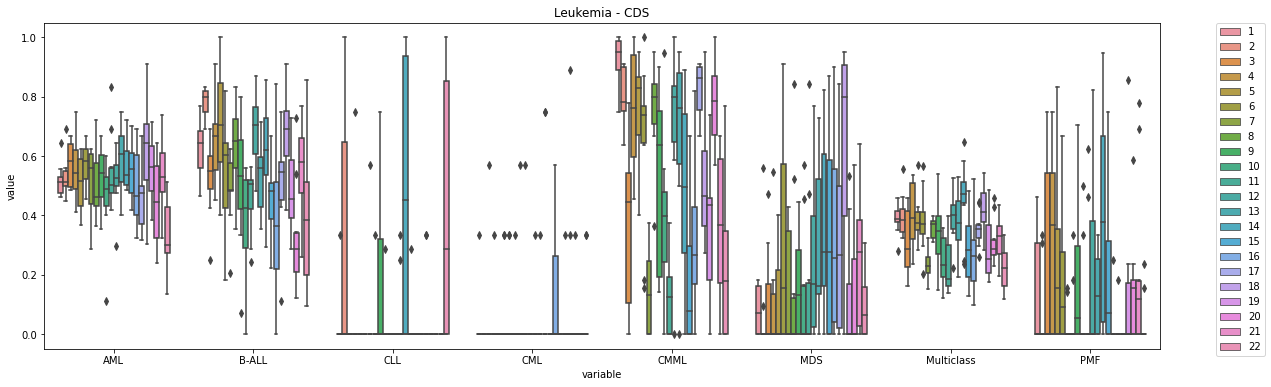

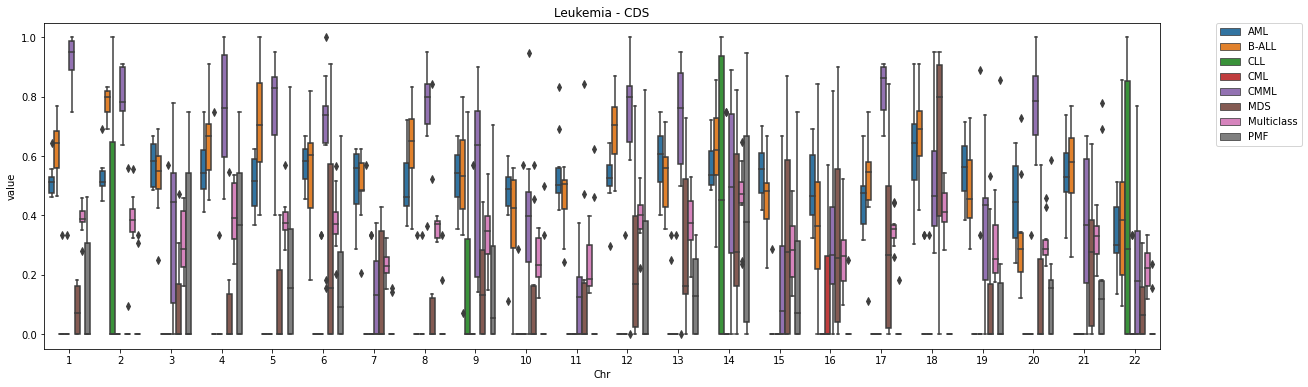

In [17]:
leu_cds_perf_df = pd.concat( leu_cds_perf )
leu_cds_perf_df = leu_cds_perf_df.reset_index(drop=True)
leu_cds_perf_df.loc[ leu_cds_perf_df.index, 'Chr' ] = leu_cds_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_cds_perf_df = leu_cds_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_cds_perf_df = leu_cds_perf_df.sort_values('Chr')
leu_cds_perf_df = leu_cds_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_cds_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - CDS' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_cds_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - CDS' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

## Running non-coding, unannotated regions

In [18]:
# Unzip the Dark data
if not os.path.isdir('Dark'):
    shutil.unpack_archive('Dark.tar.gz', '.')

In [ ]:

dark_files = [ x for x in os.listdir( 'Dark' ) if ( 'Perm' not in x ) ]
leu_dark_perf = []
for fl in dark_files:
    res = example_reveal_learning(os.path.join( 'Dark', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_dark_perf.append(res)


In [ ]:
leu_dark_perf_df = pd.concat( leu_dark_perf )
leu_dark_perf_df = leu_dark_perf_df.reset_index(drop=True)
leu_dark_perf_df.loc[ leu_dark_perf_df.index, 'Chr' ] = leu_dark_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_dark_perf_df = leu_dark_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_dark_perf_df = leu_dark_perf_df.sort_values('Chr')
leu_dark_perf_df = leu_dark_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_dark_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - Dark' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_dark_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - Dark' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

## Running whole genome

In [ ]:
# Unpack the Whole Genome region files
if not os.path.isdir('WG'):
    shutil.unpack_archive('WG.tar.gz', '.')

In [ ]:

wg_files = [ x for x in os.listdir( 'WG' ) if ( 'Perm' not in x ) ]
leu_wg_perf = []
for fl in wg_files:
    res = example_reveal_learning(os.path.join( 'WG', fl ) )
    res.loc[ res.index, 'File' ] = [fl] * len(res)
    leu_wg_perf.append(res)


In [ ]:
leu_wg_perf_df = pd.concat( leu_wg_perf )
leu_wg_perf_df = leu_wg_perf_df.reset_index(drop=True)
leu_wg_perf_df.loc[ leu_wg_perf_df.index, 'Chr' ] = leu_wg_perf_df['File'].map( lambda x: int( re.sub( '-.*', '', re.sub( '^.*Chr', '', x ) ) ) )
leu_wg_perf_df = leu_wg_perf_df.melt( id_vars = ['File', 'Fold', 'Chr'] )
leu_wg_perf_df = leu_wg_perf_df.sort_values('Chr')
leu_wg_perf_df = leu_wg_perf_df.sort_values('variable')

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_wg_perf_df, x = 'variable', y = 'value', hue = 'Chr' )
plt.title( 'Leukemia - WG' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()

plt.figure( figsize = (20,6) )
sns.boxplot( data = leu_wg_perf_df, x = 'Chr', y = 'value', hue = 'variable' )
plt.title( 'Leukemia - WG' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.close()